# **NHL Interview Prediction AI**

## **Section 1: Setup & Import** <a id="functions"></a>

In [ ]:
# verify the python version being used is from hockey_ai virtual environment
!which python

/Users/liammckendry/hockey_ai/bin/python


In [1]:
# 🚀 Always run this cell first! It contains all necessary imports.

import gc
import sys
import pprint
import os

import requests
import json

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, InputExample, losses

import torch
from torch.utils.data import DataLoader
from datasets import Dataset

import pickle
import joblib

from bs4 import BeautifulSoup

import re

import time
import random

In [2]:
import nltk
print(nltk.data.path)

['/Users/liammckendry/nltk_data', '/Users/liammckendry/hockey_ai/nltk_data', '/Users/liammckendry/hockey_ai/share/nltk_data', '/Users/liammckendry/hockey_ai/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [3]:
# Import NLTK = Natural Language Toolkit
# Used for text processing (eg. tokenization, stemming, classification, parsing, tagging, and semantic reasoning)
# NLTK is a leading platform for building Python programs to work with human language data for applying in statistical natural language processing (NLP)
# NLTK is intended to support research and teaching in NLP or closely related areas, including empirical linguistics, cognitive science, artificial intelligence, information retrieval, and machine learning.
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Verify stopwords
stop_words = set(stopwords.words('english'))
print("Stopwords loaded successfully.")

# Verify wordnet
synset = wordnet.synsets('example')
print("Wordnet loaded successfully.")

Stopwords loaded successfully.
Wordnet loaded successfully.


## **Section 2: Functions** <a id="functions"></a>

In [4]:
# Function to display HTML source structure for a given URL
# Arguments: (1) Pass a URL of the webpage to investigate, (2) the HTML tag (eg <p>) to filter the output
# Output: prints the instances of the HTML tag and their surrounding context using the prettify() method
# Note: This function is useful for understanding the structure of the HTML content

def display_html_structure(url, html_tag):
    # Fetch the HTML content
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise error if request fails

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all instances of the HTML tag
    tags = soup.find_all(html_tag)

    print(f"Found {len(tags)} instances of the tag '{html_tag}'")

    # Print the surrounding HTML for each tag
    for tag in tags:
        print(tag.prettify())
        print("\n" + "="*80 + "\n")

In [5]:
# Find the HTML tag containing a specific string
# Arguments: (1) URL of the webpage to search, (2) the string to search for
# Output: the HTML tag name containing the search string
# Note: This function is useful for finding the HTML tag that contains a specific string
def find_html_tag(url, search_string):
    # Fetch the HTML content
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise error if request fails

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Search for the string in the HTML content
    # The `string` argument filters the search to only the text content of the tags
    # The `parent` attribute then returns the parent tag of the text
    tag = soup.find(string=lambda text: search_string in text)

    if tag:
        return tag.parent.name
    else:
        return None

In [6]:
# Function to scrape the questions and answers from an interview page
# Arguments: URL of the interview page
# Output: DataFrame with columns "Question" and "Answer"
# Note: This function is specific to the structure of the interview page
# It may need to be modified for different websites or pages   
def scrape_interview(url):
    
    # Fetch the HTML content
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise error if request fails

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    """ Removed because Game Day Quotes is not consistent in all pages
    # Find the <h3> tag containing "Game Day Quotes"
    # This is where the interview questions start on the web pages
    # I found Game Day Quotes are in <h3> tag by inspecting the page source
    quotes_header_tag = soup.find('h3', string=lambda text: "Game Day Quotes" in text if text else False)

    if not quotes_header_tag:
        print("The 'Game Day Quotes' string was not found in any <h3> tag.")
        return

    # Extract the content after the <h3> tag
    # Find_next_siblings returns a list of the siblings after the <h3> tag
    content_after_header = quotes_header_tag.find_next_siblings()

    # Find all <p> tags in the content after the Game Day Quotes header
    p_tags = []
    for content in content_after_header:
        p_tags.extend(content.find_all("p"))
    """
    # Find all <p> tags in the content
    p_tags = soup.find_all("p")
    
    # Extract questions and answers
    questions = []
    answers = []
    current_question = None
    current_answer = ""

    for i, p in enumerate(p_tags):
        # Check if the <p> tag is inside a <blockquote> tag
        if p.find_parent("blockquote"):
            # This is part of an answer
            if current_question is not None:
                # Concatenate the current answer with the previous answer (all the <p> tags inside the <blockquote> tag)
                current_answer += p.get_text(strip=True) + " "
        else:
            # Check if the next tag is a <blockquote> tag
            # This indicates that the current <p> tag is a question
            # If not, it is part of the answer
            # Two checks: if i + 1 is within the list and if the next tag is a <blockquote> tag
            if i + 1 < len(p_tags) and p_tags[i + 1].find_parent("blockquote"):
                # This is a question
                if current_question is not None:
                    # Append the previous question and its answers to the lists
                    questions.append(current_question)
                    answers.append(current_answer.strip())
                    current_answer = ""

                # Start a new question
                current_question = p.get_text(strip=True)

    # Append the last question and answer if they exist
    if current_question is not None:
        questions.append(current_question)
        answers.append(current_answer.strip())

    # Pair questions with answers and include the URL
    interview_data = []
    for question, answer in zip(questions, answers):
        interview_data.append({"URL": url, "Question": question, "Answer": answer})

    return interview_data

In [7]:
url = "https://mapleleafshotstove.com/2025/02/23/toronto-maple-leafs-vs-chicago-blackhawks-game-57-preview-projected-lines-tv-broadcast-info/"
scrape_interview(url)

[{'URL': 'https://mapleleafshotstove.com/2025/02/23/toronto-maple-leafs-vs-chicago-blackhawks-game-57-preview-projected-lines-tv-broadcast-info/',
  'Question': 'Interim Blackhawks head coach Anders Sorensen on his team’s source of motivation in a non-competitive season:',
  'Answer': 'That is a good question. You have pride, right? You have pride as a player. You have pride as a group. Let’s be honest. There are a lot of guys who are playing for their future here, whether it is for us or for someone else. You have to be ready to go. It is a business. That is where it is at. You have to take pride in what you are doing. I don’t think it should matter where you are in the standings at this point. You have to take pride in what you are doing if you are a pro. That is the biggest part of it.'},
 {'URL': 'https://mapleleafshotstove.com/2025/02/23/toronto-maple-leafs-vs-chicago-blackhawks-game-57-preview-projected-lines-tv-broadcast-info/',
  'Question': 'Craig Berube on the keys to victory

In [8]:
# Function to find interview page URLs
# Main URL has multiple pages with interview links
# Arguments: (1) Main URL, (2) Maximum number of pages to search
# Output: List of URLs of interview pages
# Note: This function is specific to the structure of the website
def find_interview_urls(main_url, max_pages):
    interview_urls = []
    headers = {"User-Agent": "Mozilla/5.0"}

    # Initialize a set to store unique URLs (across pages)
    unique_urls = set()
    
    # Iterate over each page on the main URL
    for page in range(1, max_pages + 1):
        # Construct the URL for the current page
        page_url = f"{main_url}/page/{page}"
        #print(f"Retrieveing page {page_url}")
        
        # Fetch the HTML content
        response = requests.get(page_url, headers=headers)
        response.raise_for_status()  # Raise error if request fails

        # Parse the HTML
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all links to interview pages
        interview_links = soup.find_all("a", href=True)

        # Find all <a> tags with href containing a date in the format yyyy/mm/dd
        for link in interview_links:
            href = link["href"]
            if re.search(r"/\d{4}/\d{2}/\d{2}/", href):
                unique_urls.add(href) # Add the URL to the set of unique URLs
                #print(f"Adding to URL scan list: {href}")

    # Convert the set back to a list
    interview_urls = list(unique_urls)
    
    return interview_urls

In [9]:
# Main function to scrape interviews from multiple pages and combine them into one dataset
def scrape_multiple_interviews(main_url, max_pages):
    # Find interview page URLs
    interview_urls = find_interview_urls(main_url, max_pages)
    print(f"Found {len(interview_urls)} interview pages")
    
    # Initialize an empty list to store all interview data
    all_interview_data = []

    # Scrape each interview page and append the data
    for url in interview_urls:
        interview_data = scrape_interview(url)

        # Check if interview_data is not None or empty before extending all_interview_data
        if interview_data:
            all_interview_data.extend(interview_data)
            print(f"URL: {url} - Number of interview questions: {len(interview_data)}")
        else:
            print(f"URL: {url} - No interview questions found")

         # Introduce a random delay
        #time.sleep(random.uniform(2, 5))  # Sleep for 2 to 5 seconds randomly

    # Convert to DataFrame
    df = pd.DataFrame(all_interview_data)

    # Save to CSV (optional)
    #df.to_csv("/Users/liammckendry/Project2_NHL_Interviews/data/all_nhl_interviews.csv", index=False)
    
    return df

In [10]:
# Function to clean text (lowercase, remove extra spaces, and punctuation)
# Arguments: text to clean
# Output: cleaned text  
# Note: This function is useful for cleaning text data before training models
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

In [11]:
# Function to lemmatize text (convert words to their base form) and stop words
# Arguments: text to lemmatize
# Output: lemmatized text (words in their base form and without stop words)
# Example: "running" -> "run"; stop words like "the", "is" are removed
# Note: This function is useful for converting words to their base form; focus on words that matter
def lemmatize_text(text):

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization

    return text.strip()

In [12]:
# Function to preprocess the interview data
# Filter out questions that start with 'photo'
# Input: DataFrame with columns "Question" and "Answer"
# Output: DataFrame with filtered questions
# Note: This function is useful for removing irrelevant questions
def filter_photo_questions(df):
    return df[~df['Question'].str.lower().str.startswith('photo')]

# Converts the Question column to lowercase
# Checks if each question starts with 'photo'
# Inverts the selection to keep only questions that do not start with 'photo'
# Returns the filtered DataFrame

In [13]:
# Function to filter out questions that are much longer than others
# Inputs: (1) DataFrame with columns "Question" and "Answer", (2) Maximum allowed length for a question
# Output: Filtered DataFrame
# Note: This function is useful for removing records that are long paragraphs and not questions
def filter_long_questions(df, max_length=200):
    return df[df['Question'].str.len() <= max_length]

In [14]:
# Function to plot the distribution of question lengths to determine the maximum length for filtering
# Inputs: DataFrame with a 'Question' column
# Output: Histogram of question lengths
# Note: Use this to see if some questions are much longer than others; to be filtered out in data processing
def plot_question_length_distribution(df):

    # Calculate the length of each question
    question_lengths = df['Question'].str.len()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(question_lengths, bins=30, edgecolor='k', alpha=0.7)
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [15]:
# Predicts the question in the dataset that is most similar to the input question, then returns that question's answer
# Arguments: (1) input question
# Output: the answer to the most similar question in the dataset
# Note: This function uses the cosine similarity between TF-IDF vectors of questions
# cosine similarity is a measure of similarity between two non-zero vectors of an inner product space
# It measures the cosine of the angle between them
def get_answer(input_question):
    # Apply the same text cleaning to the input question
    # This ensures that the input question is processed in the same way as the questions in the dataset
    cleaned_input_question = clean_text(input_question)
    cleaned_input_question = lemmatize_text(cleaned_input_question)

    # Transform the input question to the same TF-IDF format
    input_vector = vectorizer.transform([cleaned_input_question])

    # Compute cosine similarity between the input and all questions
    # The result is a 1D array of similarity scores
    # Each element of the array corresponds to the similarity score of the input question with a question in the dataset
    similarity_scores = cosine_similarity(input_vector, question_vectors)

    # Get the index of the most similar question
    # argmax returns the index of the maximum value in the array (i.e. the highest similarity score)
    best_match_index = similarity_scores.argmax()

    # Return the corresponding answer
    # iloc is used to access the row by integer index 
    # the best match index = row number of question in the dataset with the highest similarity
    return df_original.iloc[best_match_index]['Answer']

In [16]:
# Retrieve answers based on the trained SBERT model
# Arguments: input question
# Output: best answer based on SBERT embedding similarity
# Note: This function uses the SBERT model to encode the input question and retrieve the best answer based on cosine similarity
def get_best_answer_SBERT(input_question):
    # Encode input question into SBERT embedding
    input_embedding = model.encode([input_question], convert_to_numpy=True)

    # Load precomputed question embeddings
    stored_embeddings = np.load("../data/nhl_question_embeddings.npy")

    # Compute cosine similarity
    similarities = cosine_similarity(input_embedding, stored_embeddings)

    # Get index of most similar question
    best_match_index = np.argmax(similarities)

    # Retrieve best answer from the original DataFrame (in text form, not embedding)
    best_answer = df_original.iloc[best_match_index]["Answer"]
    
    return best_answer


In [17]:
# Function to calculate the accuracy of exact matches between expected answers and predicted answers.
# Parameters: (1) List of expected answers, (2) List of predicted answers
# Returns: The accuracy of the exact matches
# Note: The function converts answers into binary (1 = correct, 0 = incorrect)
# The accuracy is the number of correct predictions divided by the total number of predictions
def calculate_exact_match_accuracy(expected_answers, predicted_answers):
    # Convert answers into binary (1 = correct, 0 = incorrect)
    y_true = np.array([1 if expected_answers[i] in predicted_answers[i] else 0 for i in range(len(expected_answers))])
    y_pred = np.ones_like(y_true)  # Since we always return an answer, assume 1

    # Calculate accuracy -- accuracy is the number of correct predictions divided by the total number of predictions
    accuracy = accuracy_score(y_true, y_pred)
    
    return accuracy

In [18]:
# Function to calculate the mean reciprocal rank (MRR) for a list of questions and their expected answers
# Arguments: (1) List of questions, (2) List of expected answers
# Output: Mean reciprocal rank
# MRR is a metric used to evaluate the effectiveness of search algorithms
# It is the average of the reciprocal ranks of the first correct answer in the ranked list of answers
# A higher MRR indicates better performance
# Note: This function uses cosine similarity to rank the answers
# The expected answer is considered correct if it is present in the top-ranked answer
# If the expected answer is not present in the ranked list, the reciprocal rank is 0 for that question
# The reciprocal rank is 1 divided by the rank of the correct answer (1-based index)
# The mean reciprocal rank is the average of the reciprocal ranks for all questions
def mean_reciprocal_rank(questions, expected_answers):
    ranks = []
    
    for i, q in enumerate(questions):
        # Clean and lemmatize the question like we do in training
        cleaned_q = clean_text(q)
        cleaned_q = lemmatize_text(cleaned_q)

        # Transform the question to the same TF-IDF format
        input_vector = vectorizer.transform([cleaned_q])

        # Compute cosine similarity between the input question and all questions in the dataset
        similarity_scores = cosine_similarity(input_vector, question_vectors)
        ranked_indices = similarity_scores.argsort()[0][::-1]  # Sort from most to least similar (i.e. rank list of questions matching input question)

        # Find rank of the correct answer
        rank = 0
        for j, index in enumerate(ranked_indices):
            if expected_answers[i] in df_original.iloc[index]['Answer']:  # Check if the expected answer is in the top-ranked answer (using original data because checking expected answer against a list before text cleaning and lemmatization)
                rank = j + 1  # Rank starts at 1
                break
        
        if rank > 0:
            ranks.append(1 / rank)

    return sum(ranks) / len(questions) if ranks else 0


In [19]:
# MRR function - updated for using SBERT model to predict best answer to question
def mean_reciprocal_rank_SBERT(questions, expected_answers):
    ranks = []
    
    for i, q in enumerate(questions):
        # Clean and lemmatize the question like we do in training
        cleaned_q = clean_text(q)
        cleaned_q = lemmatize_text(cleaned_q)

        # Transform the question to the same embedding as the SBERT model
        input_embedding = model.encode([cleaned_q], convert_to_numpy=True)

        # Load precomputed question embeddings of SBERT model on training questions
        stored_embeddings = np.load("../data/nhl_question_embeddings.npy")

        # Compute cosine similarity between the input question and all questions in the dataset
        similarity_scores = cosine_similarity(input_embedding, stored_embeddings)
        ranked_indices = similarity_scores.argsort()[0][::-1]  # Sort from most to least similar (i.e. rank list of questions matching input question)

        # Find rank of the correct answer
        rank = 0
        for j, index in enumerate(ranked_indices):
            if expected_answers[i] in df_original.iloc[index]['Answer']:  # Check if the expected answer is in the top-ranked answer (using original data because checking expected answer against a list before text cleaning and lemmatization)
                rank = j + 1  # Rank starts at 1
                break
        
        if rank > 0:
            ranks.append(1 / rank)

        # Print the question, answer, and rank
        print(f"Question: {q}")
        print(f"Expected Answer: {expected_answers[i]}")
        print(f"Rank: {rank}")
        print(f"Top 5 Similar Questions and Answers:")
        for k in range(min(5, len(ranked_indices))):
            top_index = ranked_indices[k]
            print(f"  Similarity Score: {similarity_scores[0][top_index]}")
            print(f"  Question: {df_original.iloc[top_index]['Question']}")
            print(f"  Answer: {df_original.iloc[top_index]['Answer']}")
        print("="*80)
        
        
    return sum(ranks) / len(questions) if ranks else 0


In [20]:
# function get a list of functions defined in notebook
def printFunctions():
    functions_list = [name for name, obj in globals().items() if callable(obj) and obj.__module__ == '__main__']
    print("📌 Functions Defined in Notebook:")
    print("\n".join(functions_list))

In [21]:
# Function to check dataset structure and print first 5 rows
def checkDataset(df):
    df.info()
    df.head()

In [22]:
#Function to print API response in a readable dictionary so we can investigate the structure
def read_APIResponseStructure(url):
    
    # Fetch game data
    response = requests.get(url)
    data = response.json()

    pp = pprint.PrettyPrinter(depth=4)  # Limits deep nesting
    pp.pprint(data)

In [23]:
# Monitor DataFrame Memory Usage

def show_memory_usage():
    """Displays memory usage of all DataFrames in global scope."""
    for var_name in list(globals()):
        var_value = globals()[var_name]
        if isinstance(var_value, (pd.DataFrame, pd.Series)):  # Check if it's a DataFrame
            print(f"{var_name}: {sys.getsizeof(var_value) / (1024 * 1024):.2f} MB")

show_memory_usage()  # Run this after loading data

In [24]:
# Delete Large DataFrames When No Longer Needed

def delete_dataframe(df):
    del df
    gc.collect()  # Force garbage collection


In [25]:
# Optimize DataFrame Column Types (from 64->32 float or int vars)

def optimize_dataframe(df):
    """Reduce memory usage by downcasting numerical columns."""
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')
    return df


In [26]:
# remove hidden variables that are taking up memory

def remove_hidden_variables():
    %reset out -f


## **Section 3: Load & Save Data** <a id="data_load"></a>

In [27]:
# Load NHL Interviews
# NB --> improvements: (1) add a file_age condition, (2) add a boolean y/n refresh, (3) turn this into general function for any dataset

# 📂 File path for the saved dataset (in a sibling folder)
file_path = "../data/all_nhl_interviews_5pages.csv"

# 🌐 URL for the NHL interviews + maximum sub-pages on main URL to scan
main_url = "https://mapleleafshotstove.com/leafs-news/game-day"
max_pages = 5

#load NHL interview data from API if file doesn't exist / not saved already
if os.path.exists(file_path):
    print("📂 Teams CSV file found! Loading from saved file...")
    df_interviews = pd.read_csv(file_path)
else:
    print("🌍 Teams CSV file not found. Fetching data from API...")
    df_interviews = scrape_multiple_interviews(main_url, max_pages)
    df_interviews.to_csv(file_path, index=False)  # Save for future use

#verify
checkDataset(df_interviews)

📂 Teams CSV file found! Loading from saved file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URL       832 non-null    object
 1   Question  832 non-null    object
 2   Answer    832 non-null    object
dtypes: object(3)
memory usage: 19.6+ KB


In [28]:
printFunctions()

📌 Functions Defined in Notebook:
display_html_structure
find_html_tag
scrape_interview
find_interview_urls
scrape_multiple_interviews
clean_text
lemmatize_text
filter_photo_questions
filter_long_questions
plot_question_length_distribution
get_answer
get_best_answer_SBERT
calculate_exact_match_accuracy
mean_reciprocal_rank
mean_reciprocal_rank_SBERT
printFunctions
checkDataset
read_APIResponseStructure
show_memory_usage
delete_dataframe
optimize_dataframe
remove_hidden_variables


## **Section 4: Data Preprocessing & Feature Engineering** <a id="data_processing"></a>

In [29]:
# Keep only the necessary columns - remove URL column as its not required for training
# remove rows with missing values
df_cleaned = df_interviews[['Question', 'Answer']].dropna() 

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  832 non-null    object
 1   Answer    832 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB


In [30]:
# Filter out questions that start with "photo" (not relevant to interview questions)
df_cleaned = filter_photo_questions(df_cleaned)

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
Index: 826 entries, 0 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  826 non-null    object
 1   Answer    826 non-null    object
dtypes: object(2)
memory usage: 19.4+ KB


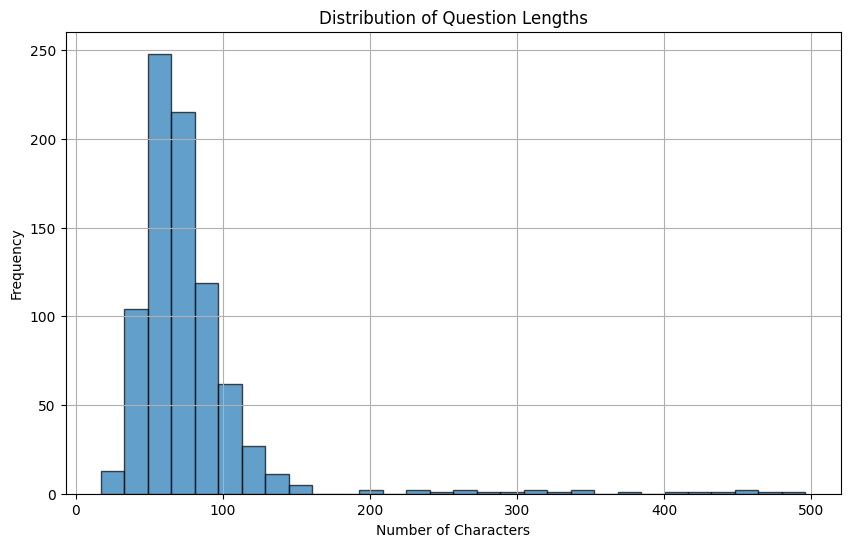

In [31]:
# Plot the distribution of question lengths to determine the maximum length for filtering
plot_question_length_distribution(df_cleaned)

In [32]:
# Filter out questions that are much longer than others
df_cleaned = filter_long_questions(df_cleaned, max_length=150)

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 1 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  802 non-null    object
 1   Answer    802 non-null    object
dtypes: object(2)
memory usage: 18.8+ KB


In [33]:
# Create a copy of the original DataFrame before cleaning
# This will be used for displaying the original questions and answers
df_original = df_cleaned.copy()

checkDataset(df_original)

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 1 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  802 non-null    object
 1   Answer    802 non-null    object
dtypes: object(2)
memory usage: 18.8+ KB


In [34]:
# Apply cleaning to both question and answer columns
df_cleaned['Question'] = df_cleaned['Question'].apply(clean_text)
df_cleaned['Answer'] = df_cleaned['Answer'].apply(clean_text)

# Display the first few cleaned rows
print(df_cleaned.head())

                                            Question  \
1     rod brindamour on craig berubes coaching style   
2  craig berube on rod brindamours coaching succe...   
3  steven lorentz on his memories of playing for ...   
4  lorentz on the similarities between brindamour...   
5  berube on the challenge presented by the hurri...   

                                              Answer  
1  he never took a shift off and thats carried ov...  
2  he has done a great job here how he played as ...  
3  i learned a lot it was how i broke into the le...  
4  there are a lot actually and same with paul ma...  
5  theyve always been a tough opponent theyve bee...  


In [35]:
# Remove stop words (common filler words) and apply lemmatization (standardize words to their base form)
df_cleaned['Question'] = df_cleaned['Question'].apply(lemmatize_text)
df_cleaned['Answer'] = df_cleaned['Answer'].apply(lemmatize_text)

# Display the first few cleaned rows
print(df_cleaned.head())

                                            Question  \
1        rod brindamour craig berubes coaching style   
2  craig berube rod brindamours coaching success ...   
3  steven lorentz memory playing brindamour carolina   
4  lorentz similarity brindamour berubes coaching...   
5               berube challenge presented hurricane   

                                              Answer  
1  never took shift thats carried coaching doesnt...  
2  done great job played player brought team work...  
3  learned lot broke league tremendous coach guy ...  
4  lot actually paul maurice last year play hard ...  
5  theyve always tough opponent theyve really goo...  


In [36]:
# Split into 90% training and 10% testing
df_train, df_test = train_test_split(df_cleaned, test_size=0.1, random_state=42)

# Extract test questions and expected answers from the original DataFrame
test_questions = df_original.loc[df_test.index, 'Question'].tolist()
expected_answers = df_original.loc[df_test.index, 'Answer'].tolist()

print(f"Number of test questions: {len(test_questions)}")


Number of test questions: 81


In [37]:
show_memory_usage()

df_interviews: 0.86 MB
df_cleaned: 0.31 MB
df_original: 0.73 MB
df_train: 0.25 MB
df_test: 0.03 MB


## **Section 5: Model 1 - Term Frequency-Inverse Document Frequency (TF-IDF)** <a id="logistic_model"></a>

### **Section 5a: Train a Model (TF-IDF)** <a id="tfidf_train"></a> ###

In [38]:
# Using the TfidfVectorizer to convert text data to numerical vectors
# This is a common technique for text data in machine learning
# It converts text data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the question text data (on the training set)
# This step calculates the IDF values for each word in the corpus
# Fit_transform learns the vocabulary and transforms the text data into vectors
question_vectors = vectorizer.fit_transform(df_train['Question'])

### **Section 5b: Evaluate/Test a Model (TF-IDF)** <a id="tfidf_eval"></a> ###

In [39]:
# Example of predicting an answer for a question using TF-IDF vectors
# The get_answer function uses cosine similarity to find the most similar question
# Then returns the answer to that question
input_question = "How did the team perform tonight?"
predicted_answer = get_answer(input_question)
print("Predicted Answer:", predicted_answer)

Predicted Answer: Opportunities are there. They hit some posts. They’ve missed the net a little bit. It is not clean as much at times, but overall, I am happy with the effort. They are working and doing the right things. The scoring will come.


In [40]:
# Predict answers for the test questions
predicted_answers = [get_answer(q) for q in test_questions]

# Calculate the accuracy of predictions using exact match (i.e., the predicted answer matches the expected answer)
accuracy = calculate_exact_match_accuracy(expected_answers, predicted_answers)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.0


In [41]:
# Compute MRR -- mean reciprocal rank
# Fuzzier evaluation by considering the rank of the correct answer in the list of predicted answers
# Higher MRR is better
mrr_score = mean_reciprocal_rank(test_questions, expected_answers)
print("Mean Reciprocal Rank (MRR):", mrr_score)


Mean Reciprocal Rank (MRR): 0.010799732287647985


**Step 5: Analyze the Results**
- **Accuracy > 70%:** Model is doing well.
- **Accuracy < 50%:** Model needs improvement (e.g., better cleaning, using embeddings instead of TF-IDF).
- **MRR > 0.7:** Correct answers appear in the top-2 results.
- **MRR < 0.4:** The model is struggling to rank answers correctly.

If both Exact Match = 100% and MRR = 1.0, it means (before we split test and training data):
- The model is retrieving perfect answers with no ranking errors.
- It’s likely overfitting or the dataset is too easy --> **test data was in the training data (previously)!**
- In real-world Q&A tasks, MRR is a better metric than Exact Match, since correct answers can be phrased differently.

If Exact Match and MRR are below 40%, 
|Issue	|Symptoms|	Solution|
|--|--|--|
|Poor text preprocessing|	Model treats "win" ≠ "winning" ≠ "victory"|	Improve text cleaning (lemmatization, stopwords)|
|Lack of understanding |	Model fails for paraphrased questions |	Use SBERT or BERT embeddings |
| Too small dataset |	Model retrieves random answers |	Expand dataset with more interview questions|
|Wrong similarity metric |	Model ranks irrelevant answers higher	| Tune TF-IDF parameters or switch to embeddings|
|Over-reliance on keywords |	Model struggles with reworded questions	|Use word embeddings instead of TF-IDF|

Update: I updated model to apply lemmatization and stop words.  Exact Match stayed at 0%.  MRR went up from 1.3 to 1.6%.  Still not significant enough.  This was with a dataset that had ~200 questions.  

The model accuracy got worse with ~800 records at 1% accuracy.

### **Section 5c: Fine-Tune the Model (TF-LDF)**  <a id="tfldf_finetune"></id>

In [42]:
# Fine tune the TF-IDF vectorizer to improve the model performance
# TfidfVectorizer parameters:
# - stop_words: Remove common words
# - ngram_range: Include word pairs (bigrams, eg "power play")
# - max_df: Ignore words in 85%+ of documents (remove common words)
# - min_df: Ignore rare words appearing in <2 docs (remove uncommon words)
# - max_features: Limit the number of features (words) to consider
# - sublinear_tf: Apply sublinear TF scaling (replace TF with 1 + log(TF))
# - use_idf: Enable inverse document frequency (IDF) reweighting
# - smooth_idf: Smooth IDF weights by adding 1 to document frequencies
# - norm: Apply L2 normalization to feature vectors
# - binary: Convert non-zero feature values to 1 (binary representation)
# - token_pattern: Regular expression pattern for tokenizing words
# - tokenizer: Custom tokenizer function (if needed, eg to keep hockey-related terms)
# - preprocessor: Custom preprocessor function (if needed)
# - lowercase: Convert text to lowercase
# - encoding: Text encoding format
# - decode_error: Error handling during text decoding
# - strip_accents: Remove accents from characters
# - analyzer: Custom analyzer for extracting features
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common words
    ngram_range=(1, 2),  # Include word pairs (bigrams)
    max_df=0.85,  # Ignore words in 85%+ of documents
    min_df=2  # Ignore rare words appearing in <2 docs
)

question_vectors = vectorizer.fit_transform(df_train['Question'])


In [43]:
# Predict answers for the test questions with fine-tuned vectorizer
predicted_answers = [get_answer(q) for q in test_questions]

# Calculate the accuracy of predictions using exact match (i.e., the predicted answer matches the expected answer)
accuracy = calculate_exact_match_accuracy(expected_answers, predicted_answers)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.0


In [44]:
# Compute MRR -- mean reciprocal rank -- with fine-tuned vectorizer
# Fuzzier evaluation by considering the rank of the correct answer in the list of predicted answers
# Higher MRR is better
mrr_score = mean_reciprocal_rank(test_questions, expected_answers)
print("Mean Reciprocal Rank (MRR):", mrr_score)


Mean Reciprocal Rank (MRR): 0.011183230323748109


Changing the parameters **increased MRR from 1.6% to 3.4%** with ~200 record data set.

Model accuracy got worse with 800 records - 0.1%

## **Section 6: Model 2 - Sentence BERT** <a id="sbert_model"></a> ##

**What is SBERT?**
- Understands sentence meaning instead of just individual words.
- Handles reworded questions better than TF-IDF.
- Uses pre-trained deep learning models to generate vector representations.
- Works well even with small datasets.


**Why is it better than TF-IDF and BERT?**
|Feature	|TF-IDF|	BERT	|SBERT|
|---|---|---|---|
|Understands Word Meaning?	|❌ No (only counts words)|	✅ Yes (deep contextual understanding)|	✅ Yes (optimized for sentence similarity)|
|Handles Synonyms?	|❌ No|	✅ Yes|	✅ Yes|
|Handles Paraphrased Questions?	|❌ No|	✅ Yes|	✅ Yes|
|Computational Efficiency	|✅ Fast|	❌ Slow|	✅ Fast|
|Requires Large Training Data?	|❌ No|	✅ Yes (requires fine-tuning)|	✅ Yes (but works well out-of-the-box)|
|Handles Short Text Well?	|✅ Yes	|✅ Yes	|✅ Yes|
|Best for Q&A Retrieval?|	❌ No|	✅ Yes (but slow)|	✅ Yes (faster than BERT)|
|Best for Sentence Similarity?|	❌ No|	✅ Yes	|✅ Yes (optimized for this)|
|Pre-trained Model Available?|	❌ No (requires manual vectorization)	|✅ Yes	|✅ Yes|
|Example Use Cases|	Search engines, keyword matching|	Chatbots, language understanding, deep NLP tasks	|Chatbots, Q&A, semantic search, recommendation systems|

### **Section 6a: Train a Model (SBERT)** <a id="sbert_train"></a> ###

In [45]:
# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

Why all-MiniLM-L6-v2?
- Fast & lightweight (smaller embedding size)
- Optimized for sentence similarity
- Good balance of accuracy vs speed

In [46]:
# Convert all stored interview questions into SBERT embeddings
question_embeddings = model.encode(df_train["Question"].tolist(), convert_to_numpy=True)

# Store embeddings for faster retrieval
np.save("../data/nhl_question_embeddings.npy", question_embeddings)


### **Section 6b: Evaluate a Model (SBERT)** <a id="sbert_eval"></a> ###

In [47]:
# Compute MRR -- mean reciprocal rank -- with interview questions trained on SBERT model
# Fuzzier evaluation by considering the rank of the correct answer in the list of predicted answers
# Higher MRR is better
mrr_score = mean_reciprocal_rank_SBERT(test_questions, expected_answers)
print("Mean Reciprocal Rank (MRR) for SBERT:", mrr_score)


Question: Berube on the reasons for theLeafs‘ success without Matthews in the past:
Expected Answer: I think everyone just digs in more. Different players get different opportunities in situations like this, whether it is more minutes or maybe they are on the power play. They elevate their game. Everybody needs to elevate their game tonight not just because Auston is out of the lineup but because we are playing the Bruins. It is going to be a good, hard game. We need everyone on board tonight.
Rank: 415
Top 5 Similar Questions and Answers:
  Similarity Score: 0.6485885977745056
  Question: Ryan Reaves on the team’s mindset heading into a Saturday night in Boston coming off two tough losses this week:
  Answer: We feel good. We had a good practice on Friday. It is not the way we wanted to play in front of the hometown against St. Louis, Chief’s old team. It was not a great game in Columbus, either, but you’re going to have those games. It is a good chance to go out and put a good foot f

### **Section 6c: Model Tuning (SBERT)** <a id="sbert_hyper"></a>

Since your Mean Reciprocal Rank (MRR) is still low (0.01), fine-tuning SBERT on NHL-specific questions and answers should improve performance.

Why Fine-Tune SBERT?
- Pretrained SBERT models work well for general sentence similarity but may not understand hockey-specific language.
- Fine-tuning adapts the model to your dataset, helping it recognize NHL-related questions and their best matches.

Fine-Tuning Process Overview
1. Prepare NHL Interview Data for Fine-Tuning
    1. Convert NHL Q&A data into (question, positive answer, negative answer) triplets.
    2. Ensure dataset contains diverse hockey-related Q&A pairs.
2. Choose a Pretrained SBERT Model
    1. Use all-MiniLM-L6-v2 for speed & efficiency.
    2.  Use all-mpnet-base-v2 if you want higher accuracy.
3. Train the Model with Triplet Loss
    1. Triplet loss ensures that:
        1. The correct answer is closer to the question than the incorrect answer.
        2. Helps SBERT learn better question-answer matching.
4. Evaluate the Fine-Tuned Model
    1. Compute MRR again to see improvements.

In [48]:
# Load & prepare data for fine-tuning SBERT model

# Load NHL dataset
df = pd.read_csv("../data/all_nhl_interviews_5pages.csv")

# Ensure the dataset has at least 3 columns: Question, Answer, Incorrect Answer
df = df.dropna(subset=["Question", "Answer"])  # Drop missing values

# Generate Negative (Incorrect) Answers by shuffling
# This is a simple way to create incorrect answers for training
# Sample(frac=1) shuffles the rows and reset_index(drop=True) resets the row indices'
# The purpose of this code is to create a negative answer that is different from the positive answer
# This is a simple way to create incorrect answers for training
df["Negative Answer"] = df["Answer"].sample(frac=1).reset_index(drop=True)

# Ensure negatives aren't the same as positives
# If the negative answer is the same as the positive answer, remove the row
df = df[df["Answer"] != df["Negative Answer"]]

# Create triplet examples for training
train_examples = [
    InputExample(texts=[row["Question"], row["Answer"], row["Negative Answer"]])
    for _, row in df.iterrows()
]

print("🔹 Sample Training Example:", train_examples[0].texts)


🔹 Sample Training Example: ['On defense, Morgan Rielly will shift next to Chris Tanev and Oliver Ekman-Larsson next to Philippe Myers (a new pairing this season),a move Anthony Petrielli advocated for in his recent notebook:', 'With Jake McCabe on IR, I’d like to see a bit more of a shake-up… The OEL-Tanev pairing wasn’t particularly strong in terms of driving play up ice, and they didn’t really bring out the best in each other (OEL wasn’t potent offensively, and Tanev wasn’t dictating play up ice as he normally does). I’d rather try Rielly-Tanev as a top pairing, considering they already saw time together and meshed much more naturally to me. It would then bump OEL to play with Myers while keeping the Benoit – Timmins pairing together. There is still familiarity with two of those pairings, and I think the combo of Rielly-Tanev gives them the best possible pairing overal. But it’s possible the other two pairings won’t be good enough to allow them to keep Rielly and Tanev together, and 

In [49]:
# Install the required packages
!pip install "accelerate>=0.26.0"
!pip install "transformers[torch]"
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# We use Triplet Loss, which forces correct answers closer to questions and incorrect answers farther away
# This is a common loss function for training models with triplet examples
# The model learns to minimize the distance between the question and correct answer while maximizing the distance between the question and incorrect answer
train_loss = losses.TripletLoss(model)

: 

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader

# Define DataLoader for training
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# Fine-tune SBERT model using the triplet loss 
# This step trains the model to minimize the triplet loss on the training data
# The model learns to encode questions and answers in a way that makes correct answers closer to questions and incorrect answers farther away
# Parameters: train_objectives: List of tuples (DataLoader, LossFunction) for training
# epochs: Number of training epochs
# warmup_steps: Number of warmup steps for learning rate scheduler
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,  # Increase epochs if needed
    warmup_steps=100  # Stabilizes learning rate
)

# Save fine-tuned model
model.save("../model/fine_tuned_sbert_nhl")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
# 🚀 Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [10, 20, None],  # Limit tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]  # Number of features per tree
}

# 🚀 Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# 🚀 Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

# 🚀 Train with hyperparameter tuning
grid_search.fit(X_train, y_train)

# 🚀 Best hyperparameters & accuracy
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("✅ Best Hyperparameters:", best_params)

# 🚀 Evaluate Tuned Model
y_pred_rf_tuned = best_rf_model.predict(X_test)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)

print(f"✅ Tuned Random Forest Accuracy: {accuracy_rf_tuned:.2%}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
✅ Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
✅ Tuned Random Forest Accuracy: 81.40%


**Interperting Best Hyperparameter Results**

|Hyperparameter|	Chosen Value|	What This Means|
|--|--|--|
|max_depth=None	|No limit on tree depth	| Trees grow fully unless stopped by other criteria.
|max_features='sqrt' |	Randomly selects √(num features) per tree	| Encourages diversity between trees (less overfitting).
|min_samples_leaf=1	|A leaf node can have just 1 sample	| Maximizes depth but may lead to overfitting.
|min_samples_split=2 |	A node splits if it has 2 or more samples |	Allows deep trees but could lead to very specific splits.
|n_estimators=50	| Uses 50 decision trees in the forest	| A smaller forest speeds up training but could be less stable.

**Should We Tune Further?**

*Pros of This Model*
- Accuracy slightly improved (81.40%) – The model is performing well.
- Uses feature randomness (sqrt) – Helps prevent overfitting.
- Fully grown trees (max_depth=None) – Allows trees to learn complex patterns.

*Possible Issues*
- Overfitting risk? min_samples_leaf=1 and max_depth=None means the trees grow very deep, capturing every small detail in the training data.
- Too few trees (n_estimators=50)? Increasing trees might improve stability at the cost of computation time.

## **Section 8: Save the Trained Model** ## <a id="save_model"></a>

Both **joblib** and **pickle** libraries are used to save and load Python objects (like machine learning models), but they work differently.

**Using joblib (Recommended for ML models)**
- import joblib
- joblib.dump(best_xgb_model, "model.pkl")  # Save
- model = joblib.load("model.pkl")  # Load

**Using pickle**
- import pickle
- with open("model.pkl", "wb") as f:
    - pickle.dump(best_xgb_model, f)
- with open("model.pkl", "rb") as f:
    - model = pickle.load(f)

**Summary: joblib.dump() vs. pickle.dump()**
|Scenario|	Use joblib?|	Use pickle?|
|--|--|--|
|Saving ML models (XGBoost, Scikit-learn)?|	✅ Yes|	❌ No|
|Saving general Python objects?	|❌ No|	✅ Yes|
|Storing large NumPy arrays?|	✅ Yes|	❌ No|
|Need speed & efficiency?	|✅ Yes|	❌ No|




In [ ]:
# pickle library saves the trained model 
# it serializes the model object into a binary format and writes it into a pkl file
# later, we'll read and load the file for use in an app

with open("xgboost_model.pkl", "wb") as model_file:
    pickle.dump(best_xgb_model, model_file)


In [ ]:
# we also need to save how the model is scaling input data so we can apply the same method in the application
#If your app (eg Flask API) does not scale the input data the same way as during training, predictions will be off.

# Check how your model was trained (re-do from Section 5c)
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Save the scaler for API use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## **Section 9: Create Team Feature Lookup** <a id="team_lookup"></a> ##

**As a more user friendly option...**
- **instead of:** users filling 10+ attributes about a team and its players for both home and away teams (which they won't know)
- **do this:** users enter two teams, and the system looks up their attributes

**Solution:** We will prepare a dataset that has features the model expects for each team, and export it to a file that the apps can look up.

In [ ]:
## export team features data frame to CSV file
df_team_features.to_csv("team_stats.csv", index=False)

In [ ]:
checkDataset(df_team_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   teamAbbrev             32 non-null     object 
 1   avg_team_weight        32 non-null     float64
 2   avg_team_height        32 non-null     float64
 3   avg_team_age           32 non-null     float64
 4   num_CAN_players        32 non-null     int64  
 5   num_FIN_players        32 non-null     int64  
 6   OTHER                  32 non-null     int64  
 7   num_RUS_players        32 non-null     int64  
 8   num_SWE_players        32 non-null     int64  
 9   num_USA_players        32 non-null     int64  
 10  num_LeftShot_players   32 non-null     int64  
 11  num_RightShot_players  32 non-null     int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 3.1+ KB


## **Section n** <a id=<tbd>></a> ##

Train an AI Model to Predict Game Winners 🏆🔮
Now that we have structured NHL game data, we can train a machine learning model to predict which team will win based on team and player attributes.

Overview: How We’ll Build the Model

1️⃣ Define the Problem – Predict whether the home team or away team will win.
2️⃣ Select Features – Choose player & team stats as inputs.
3️⃣ Prepare the Dataset – Convert categorical data, handle missing values.
4️⃣ Train Machine Learning Models – Use Logistic Regression, Random Forest, or XGBoost.
5️⃣ Evaluate Model Performance – Check accuracy, precision, recall.
6️⃣ Make Predictions on Future Games – Predict upcoming match results.